This notebook lays out the initial set of analyses performed by RP using multidimensional item response theory (MIRT) on a subset of the UH2 discovery sample.  

For the analyses of the survey data, we have discussed two potential approaches, to be pursued in parallel.  One is to examine the survey results using the standard subscales associated with each survey; that approach is not addressed here.  The second, which I focus on here, is to estimate a set of factors without regard to the inventories from which the surveys come, in essence treating them as a "bag of items".  

This notebook was first developed on the discovery sample.  Because fit of the mirt model was problematic with smaller samples, we chose to fit it to the full discovery sample. The items were cleaned in order to collapse extreme item  responses that occurred less than 40 times across subjects, as well as removing items that had more than 5 missing responses across subjects.



In [1]:
# first, set up our imports and configuration

import os,glob,pickle,sys
import json
import importlib

import pandas
import networkx as nx
import numpy
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display, HTML
pandas.set_option('max_colwidth', 100)


%load_ext rpy2.ipython

%matplotlib inline

# this is kludgey but it works
sys.path.append('../utils')
from show_image import showPDF

from utils import get_info,get_behav_data
from metadata_utils import load_metadata
dataset=get_info('dataset')
print('using dataset:',dataset)
basedir=get_info('base_directory')
derived_dir=os.path.join(basedir,'Data/Derived_Data/Combined_12-05-2016')


/Users/poldrack/anaconda/envs/py34/lib/python3.4/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


using dataset: Complete_12-15-2016


In [2]:
behavdata=get_behav_data(dataset,full_dataset=True)
data=pandas.DataFrame.from_csv('../Data/Derived_Data/Combined_12-15-2016/surveydata_fixed_minfreq40.csv')
survey_metadata = pickle.load(open(os.path.join(basedir,'Data/Derived_Data/Discovery_12-05-2016/survey_metadata.pkl'),'rb'))


Getting datasets...:
 /Users/poldrack/code/Self_Regulation_Ontology/Data/Complete_12-15-2016


In [3]:
print('Processed the following surveys for %d subjects:'%data.shape[0])
print('data stored in %s'%derived_dir)
print('')
surveyinfo=[]
all_metadata={}
for k in survey_metadata.keys():
    surveyinfo.append([k.replace('_survey',''),len(survey_metadata[k])-1])
    for kk in survey_metadata[k].keys():
        if kk=='MeasurementToolMetadata':
            continue
        all_metadata[kk]=survey_metadata[k][kk]
df=pandas.DataFrame(surveyinfo,columns=['SurveyName','NumberOfItems'])
display(df)
print(df.NumberOfItems.sum(),'items total')


Processed the following surveys for 522 subjects:
data stored in /Users/poldrack/code/Self_Regulation_Ontology/Data/Derived_Data/Combined_12-05-2016



,SurveyName,NumberOfItems
0,time_perspective,56
1,self_regulation,30
2,brief_self_control,13
3,future_time_perspective,10
4,upps_impulsivity,59
5,theories_of_willpower,12
6,dospert_rt,30
7,dospert_eb,30
8,five_facet_mindfulness,39
9,impulsive_venture,34


594 items total


### MIRT analyses

I then used the R mirt package to run exploratory multidimensional IRT analyses, using a graded response model with the Metropolis-Hastings Robbins-Monro (MHRM) algorithm so that I could successfully fit the larger models.  In the example shown below, I fit models with dimensionalities from 1 to 10.  I then characterized each dimension by examining the items that had the highest/lowest scores on each one and giving a summary label (which was sometimes difficult, in which case I just used "unknown").  See run_mirt.R for details on how the model was run.





Now let's load in the models from each dimensionality (run on the cluster) and save their latent scores so that we can load them into python and have a look. (this is adapted from summarize_mirt.R)

In [4]:
datfiles=glob.glob('output/*Rdata')
compnums=[int(i.split('/')[1].replace('mirt_','').replace('dims_graded.Rdata','')) for i in datfiles]
compnums.sort()
print(compnums)
if not os.path.exists('mirt_scores'):
    os.mkdir('mirt_scores')
if not os.path.exists('subject_scores'):
    os.mkdir('subject_scores')
    
%load_ext rpy2.ipython
%R require('mirt')

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


/Users/poldrack/anaconda/envs/py34/lib/python3.4/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Loading required package: mirt

  warnings.warn(x, RRuntimeWarning)
/Users/poldrack/anaconda/envs/py34/lib/python3.4/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Loading required package: stats4

  warnings.warn(x, RRuntimeWarning)
/Users/poldrack/anaconda/envs/py34/lib/python3.4/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Loading required package: lattice

  warnings.warn(x, RRuntimeWarning)


array([1], dtype=int32)

In [5]:
%%R -i compnums -o converged,aic,bic
#compnums=c(1,2,3,4,5,6,8,9,10)
converged=array(dim=length(compnums))
aic=array(dim=length(compnums))
bic=array(dim=length(compnums))

for (i in 1:length(compnums)) {
  ncomps=compnums[i]
  load(sprintf('output/mirt_%ddims_graded.Rdata',ncomps))
  converged[i]=m@OptimInfo$converged
  aic[i]=m@Fit$AIC
  bic[i]=m@Fit$BIC

  s=summary(m,verbose=FALSE)
  scores=s$rotF
  write.table(scores,file=sprintf('mirt_scores/mirt_scores_%ddims.tsv',ncomps),sep='\t',quote=FALSE,col.names=FALSE)
  #subscores=fscores(m,method='MAP')
  #write.table(subscores,file=sprintf('subject_scores/subject_scores_%ddims.tsv',ncomps),sep='\t',quote=FALSE,col.names=FALSE)
}

Plot some convergence statistics for each model - whereas the higher-dimension models did not converge for the previous discovery analyses, all of them converge with the full dataset.

,AIC,BIC,converged
1,inf,inf,1
2,5.687368e+05,5.792319e+05,1
3,5.656488e+05,5.785070e+05,1
4,5.596365e+05,5.748534e+05,1
5,5.600875e+05,5.776588e+05,1
6,5.449005e+05,5.648221e+05,1
7,5.464351e+05,5.687027e+05,1
8,5.473591e+05,5.719685e+05,1
9,5.493944e+05,5.763411e+05,1
10,5.526681e+05,5.819481e+05,1


AIC chooses 6 dimensions
BIC chooses 6 dimensions


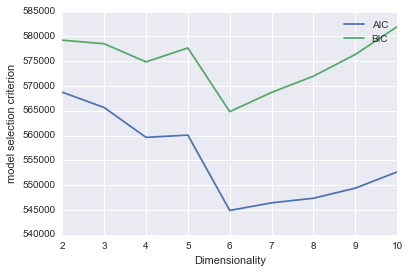

In [6]:
# print out some convergence statistics for each model
df=pandas.DataFrame({'converged':converged,'AIC':aic,'BIC':bic},index=compnums)
display(df)
plt.plot(compnums,aic)
plt.plot(compnums,bic)

plt.xlabel('Dimensionality')
plt.ylabel('model selection criterion')
plt.legend(['AIC','BIC'])
print('AIC chooses %d dimensions'%(numpy.argmin(aic)+1))
print('BIC chooses %d dimensions'%(numpy.argmin(bic)+1))

Now let's look at the results from each model.   First we need to set up a dictionary with the subjective labels NB: These are manually generated using the results from below.

In [7]:
compdesc={}
compdesc[1]=['persistence']
compdesc[2]=['persistence','risk/nonplanning']
compdesc[3]=['persistence','risk/nonplanning','internalizing']
compdesc[4]=['nonplanning','sensation-seeking','persistence','internalizing']
compdesc[5]=['nonplanning','sensation-seeking','persistence','internalizing',
            'positive-urgency']
compdesc[6]=['persistence','sensation-seeking','emotion regulation','nonplanning/risk',
            'positive-urgency','past-negative']
compdesc[7]=['positive-urgency','sensation-seeking','risk','persistence',
             'goal-directedness','past-negative','emotion regulation']
compdesc[8]=['positive-urgency','sensation-seeking','risk',
            'future-negative','persistence','past-negative','social risk',
            'mindfulness']
compdesc[9]=['positive-urgency','sensation-seeking','gambling','social risk','persistence',
             'past-negative','mindful observing','mindful attention','emotional eating/self-control']
compdesc[10]=['positive-urgency','sensation-seeking','emotional eating/self-control','nonplanning',
              'persistence','gambling','past-positive','mindful attention',
              'mindful observing','future time']

Now let's list the items with top positive and negative scores for each latent dimension, along with the subjective label.

In [8]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;


<IPython.core.display.Javascript object>

In [9]:
compnums=[int(i.split('/')[1].replace('mirt_','').replace('dims_graded.Rdata','')) for i in datfiles]
compnums.sort()
mirt_scores={}
for c in range(10):
    ncomps=compnums[c]
    scdata=pandas.read_csv('mirt_scores/mirt_scores_%ddims.tsv'%ncomps,
                         delimiter='\t',header=None,names=['itemname']+['score%d'%int(i+1) for i in range(ncomps)])
    scdata=scdata[scdata.itemname != 'X']
    mirt_scores[ncomps]=scdata
    print('')
    for d in range(ncomps):
        print('%d Components: Dimension %d (%s)'%(ncomps,d+1,compdesc[ncomps][d]))
        cdata=scdata.sort_values(by='score%d'%int(d+1))
        lowdata=cdata.iloc[:3,[0,d+1]]
        highdata=cdata.iloc[-3:,[0,d+1]]
        data_show=pandas.concat([lowdata,highdata])
        itemtext=[]
        for item in data_show['itemname']:
            itemtext.append(all_metadata[item]['Description'])
        data_show['itemtext']=itemtext
        display(data_show)    


1 Components: Dimension 1 (persistence)


,itemname,score1,itemtext
506,upps_impulsivity_survey.10,-0.662840,I tend to give up easily.
501,upps_impulsivity_survey.05,-0.545143,I generally like to see things through to the end.
539,upps_impulsivity_survey.43,-0.545013,I almost always finish projects that I start.
365,self_regulation_survey.17,0.612520,I have a hard time setting goals for myself.
362,self_regulation_survey.14,0.628849,I am able to accomplish goals for myself.
360,self_regulation_survey.12,0.637185,I give up quickly.



2 Components: Dimension 1 (persistence)


,itemname,score1,itemtext
506,upps_impulsivity_survey.10,-0.629134,I tend to give up easily.
524,upps_impulsivity_survey.28,-0.516980,I finish what I start.
539,upps_impulsivity_survey.43,-0.504742,I almost always finish projects that I start.
362,self_regulation_survey.14,0.558374,I am able to accomplish goals for myself.
64,brief_self_control_survey.12,0.560099,I am able to work effectively toward long-term goals.
360,self_regulation_survey.12,0.593096,I give up quickly.


2 Components: Dimension 2 (risk/nonplanning)


,itemname,score2,itemtext
265,impulsive_venture_survey.04,-0.765468,Do you quite enjoy taking risks?
520,upps_impulsivity_survey.24,-0.619361,I quite enjoy taking risks.
528,upps_impulsivity_survey.32,-0.597315,"I welcome new and exciting experiences and sensations, even if they are a little frightening and..."
315,mpq_control_survey.10,0.480550,I do things on the spur of the moment.
317,mpq_control_survey.13,0.501934,I am cautious person.
318,mpq_control_survey.14,0.508522,I am a spontaneous person.



3 Components: Dimension 1 (persistence)


,itemname,score1,itemtext
501,upps_impulsivity_survey.05,-0.559648,I generally like to see things through to the end.
506,upps_impulsivity_survey.10,-0.495362,I tend to give up easily.
534,upps_impulsivity_survey.38,-0.493890,I am a person who always gets the job done.
368,self_regulation_survey.20,0.523848,I set goals for myself and keep track of my progress.
365,self_regulation_survey.17,0.525215,I have a hard time setting goals for myself.
375,self_regulation_survey.28,0.545298,"Once I have a goal, I can usually plan how to reach it."


3 Components: Dimension 2 (risk/nonplanning)


,itemname,score2,itemtext
265,impulsive_venture_survey.04,-0.664815,Do you quite enjoy taking risks?
520,upps_impulsivity_survey.24,-0.526553,I quite enjoy taking risks.
273,impulsive_venture_survey.12,-0.505194,Do you welcome new and exciting experiences and sensations even if they are a little frightening...
315,mpq_control_survey.10,0.409061,I do things on the spur of the moment.
318,mpq_control_survey.14,0.427709,I am a spontaneous person.
317,mpq_control_survey.13,0.437856,I am cautious person.


3 Components: Dimension 3 (internalizing)


,itemname,score3,itemtext
269,impulsive_venture_survey.08,-0.484185,Do you often get into a jam because you do things without thinking?
45,bis_bas_survey.17,-0.442714,If I think something unpleasant is going to happen I usually get pretty 'worked up.
53,bis_bas_survey.25,-0.436137,I worry about making mistakes.
60,brief_self_control_survey.08,0.348754,I wish I had more self-discipline.
323,mpq_control_survey.19,0.380135,I am very level-headed.
423,ten_item_personality_survey.06,0.388857,"Anxious, easily upset."



4 Components: Dimension 1 (nonplanning)


,itemname,score1,itemtext
272,impulsive_venture_survey.11,-0.702474,Are you an impulsive person?
449,time_perspective_survey.09,-0.649433,I do things impulsively.
44,bis_bas_survey.16,-0.605631,I often act on the spur of the moment.
316,mpq_control_survey.12,0.488681,I am not as cautious.
318,mpq_control_survey.14,0.503260,I am a spontaneous person.
315,mpq_control_survey.10,0.563377,I do things on the spur of the moment.


4 Components: Dimension 2 (sensation-seeking)


,itemname,score2,itemtext
166,dospert_rt_survey.20,-0.641245,Taking a skydiving class.
543,upps_impulsivity_survey.47,-0.635035,I would enjoy the sensation of skiing very fast down a high mountain slope.
402,sensation_seeking_survey.24,-0.634843,Please indicate which of the following scenarios you would prefer.
128,dospert_rp_survey.12,0.350424,Going down a ski run that is beyond your ability.
143,dospert_rp_survey.27,0.370731,Walking home alone at night in an unsafe area of town.
141,dospert_rp_survey.25,0.407224,Bungee jumping off a tall bridge.


4 Components: Dimension 3 (persistence)


,itemname,score3,itemtext
375,self_regulation_survey.28,-0.623769,"Once I have a goal, I can usually plan how to reach it."
368,self_regulation_survey.20,-0.608672,I set goals for myself and keep track of my progress.
365,self_regulation_survey.17,-0.601162,I have a hard time setting goals for myself.
506,upps_impulsivity_survey.10,0.537668,I tend to give up easily.
534,upps_impulsivity_survey.38,0.556072,I am a person who always gets the job done.
501,upps_impulsivity_survey.05,0.630589,I generally like to see things through to the end.


4 Components: Dimension 4 (internalizing)


,itemname,score4,itemtext
53,bis_bas_survey.25,-0.521611,I worry about making mistakes.
491,time_perspective_survey.51,-0.479065,I think about the bad things that have happened to me in the past.
457,time_perspective_survey.17,-0.452300,Painful past experiences keep being replayed in my mind.
235,five_facet_mindfulness_survey.31,0.475338,I think some of my emotions are bad or inappropriate and I shouldnt feel them.
230,five_facet_mindfulness_survey.26,0.482635,I tell myself that I shouldnt be thinking the way Im thinking.
219,five_facet_mindfulness_survey.15,0.505700,I believe some of my thoughts are abnormal or bad and I shouldnt think that way.



5 Components: Dimension 1 (nonplanning)


,itemname,score1,itemtext
276,impulsive_venture_survey.15,-0.664998,Do you often do things on the spur of the moment?
272,impulsive_venture_survey.11,-0.657054,Are you an impulsive person?
274,impulsive_venture_survey.13,-0.540585,Do you usually think carefully before doing anything?
316,mpq_control_survey.12,0.462898,I am not as cautious.
318,mpq_control_survey.14,0.522254,I am a spontaneous person.
315,mpq_control_survey.10,0.600702,I do things on the spur of the moment.


5 Components: Dimension 2 (sensation-seeking)


,itemname,score2,itemtext
265,impulsive_venture_survey.04,-0.603978,Do you quite enjoy taking risks?
281,impulsive_venture_survey.20,-0.598521,Do you sometimes like doing things that are a bit frightening?
273,impulsive_venture_survey.12,-0.566751,Do you welcome new and exciting experiences and sensations even if they are a little frightening...
317,mpq_control_survey.13,0.256986,I am cautious person.
143,dospert_rp_survey.27,0.281915,Walking home alone at night in an unsafe area of town.
141,dospert_rp_survey.25,0.309685,Bungee jumping off a tall bridge.


5 Components: Dimension 3 (persistence)


,itemname,score3,itemtext
368,self_regulation_survey.20,-0.574924,I set goals for myself and keep track of my progress.
375,self_regulation_survey.28,-0.569270,"Once I have a goal, I can usually plan how to reach it."
361,self_regulation_survey.13,-0.543468,I usually keep track of my progress toward my goals.
534,upps_impulsivity_survey.38,0.501919,I am a person who always gets the job done.
524,upps_impulsivity_survey.28,0.514367,I finish what I start.
501,upps_impulsivity_survey.05,0.539231,I generally like to see things through to the end.


5 Components: Dimension 4 (internalizing)


,itemname,score4,itemtext
53,bis_bas_survey.25,-0.499590,I worry about making mistakes.
491,time_perspective_survey.51,-0.485116,I think about the bad things that have happened to me in the past.
45,bis_bas_survey.17,-0.434158,If I think something unpleasant is going to happen I usually get pretty 'worked up.
215,five_facet_mindfulness_survey.11,0.409674,I tell myself I shouldnt be feeling the way Im feeling.
230,five_facet_mindfulness_survey.26,0.413379,I tell myself that I shouldnt be thinking the way Im thinking.
219,five_facet_mindfulness_survey.15,0.422991,I believe some of my thoughts are abnormal or bad and I shouldnt think that way.


5 Components: Dimension 5 (positive-urgency)


,itemname,score5,itemtext
527,upps_impulsivity_survey.31,-0.636200,Others would say I make bad choices when I am extremely happy about something.
542,upps_impulsivity_survey.46,-0.631017,"When overjoyed, I feel like I cant stop myself from going overboard."
537,upps_impulsivity_survey.41,-0.594541,"When I get really happy about something, I tend to do things that can have bad consequences."
308,mindful_attention_awareness_survey.13,0.279558,I drive places on 'automatic pilot' and then wonder why I went there.
66,brief_self_control_survey.14,0.287492,I often act without thinking through all the alternatives.
373,self_regulation_survey.26,0.299627,Most of the time I don't pay attention to what I'm doing.



6 Components: Dimension 1 (persistence)


,itemname,score1,itemtext
524,upps_impulsivity_survey.28,-0.765107,I finish what I start.
539,upps_impulsivity_survey.43,-0.727783,I almost always finish projects that I start.
534,upps_impulsivity_survey.38,-0.725744,I am a person who always gets the job done.
261,grit_scale_survey.08,0.729575,I finish whatever I begin.
337,selection_optimization_compensation_survey.10,0.732351,Please select which of the two statements is more true for you.
368,self_regulation_survey.20,0.742725,I set goals for myself and keep track of my progress.


6 Components: Dimension 2 (sensation-seeking)


,itemname,score2,itemtext
281,impulsive_venture_survey.20,-0.840402,Do you sometimes like doing things that are a bit frightening?
266,impulsive_venture_survey.05,-0.837016,Would you enjoy parachute jumping?
402,sensation_seeking_survey.24,-0.836674,Please indicate which of the following scenarios you would prefer.
141,dospert_rp_survey.25,0.423677,Bungee jumping off a tall bridge.
318,mpq_control_survey.14,0.437116,I am a spontaneous person.
317,mpq_control_survey.13,0.479476,I am cautious person.


6 Components: Dimension 3 (emotion regulation)


,itemname,score3,itemtext
52,bis_bas_survey.24,-0.509855,It would excite me to win a contest.
36,bis_bas_survey.08,-0.495531,"When I get something I want, I feel excited and energized."
43,bis_bas_survey.15,-0.464994,When I see an opportunity for something I like I get excited right away.
257,grit_scale_survey.04,0.312876,I have been obsessed with a certain idea or project for a short time but later lost interest.
255,grit_scale_survey.02,0.345658,New ideas and projects sometimes distract me from previous ones.
199,erq_survey.05,0.489630,"When I am feeling <i>positive</i> emotions, I am careful not to express them."


6 Components: Dimension 4 (nonplanning/risk)


,itemname,score4,itemtext
116,dospert_eb_survey.30,-0.514988,Leaving your young children alone at home while running an errand.
95,dospert_eb_survey.09,-0.490263,Betting a day's income at a high-stake poker game.
97,dospert_eb_survey.11,-0.481227,Passing off somebody elses work as your own.
268,impulsive_venture_survey.07,0.485905,Do you generally do and say things without stopping to think?
274,impulsive_venture_survey.13,0.498270,Do you usually think carefully before doing anything?
276,impulsive_venture_survey.15,0.540914,Do you often do things on the spur of the moment?


6 Components: Dimension 5 (positive-urgency)


,itemname,score5,itemtext
542,upps_impulsivity_survey.46,-0.876364,"When overjoyed, I feel like I cant stop myself from going overboard."
527,upps_impulsivity_survey.31,-0.864080,Others would say I make bad choices when I am extremely happy about something.
537,upps_impulsivity_survey.41,-0.834936,"When I get really happy about something, I tend to do things that can have bad consequences."
373,self_regulation_survey.26,0.450754,Most of the time I don't pay attention to what I'm doing.
319,mpq_control_survey.15,0.469164,I do the first thing that comes to mind.
66,brief_self_control_survey.14,0.526037,I often act without thinking through all the alternatives.


6 Components: Dimension 6 (past-negative)


,itemname,score6,itemtext
491,time_perspective_survey.51,-0.705244,I think about the bad things that have happened to me in the past.
457,time_perspective_survey.17,-0.659678,Painful past experiences keep being replayed in my mind.
475,time_perspective_survey.35,-0.648894,It's hard for me to forget unpleasant images of my youth.
235,five_facet_mindfulness_survey.31,0.605582,I think some of my emotions are bad or inappropriate and I shouldnt feel them.
215,five_facet_mindfulness_survey.11,0.612682,I tell myself I shouldnt be feeling the way Im feeling.
219,five_facet_mindfulness_survey.15,0.628897,I believe some of my thoughts are abnormal or bad and I shouldnt think that way.



7 Components: Dimension 1 (positive-urgency)


,itemname,score1,itemtext
527,upps_impulsivity_survey.31,-0.839145,Others would say I make bad choices when I am extremely happy about something.
542,upps_impulsivity_survey.46,-0.828197,"When overjoyed, I feel like I cant stop myself from going overboard."
537,upps_impulsivity_survey.41,-0.803819,"When I get really happy about something, I tend to do things that can have bad consequences."
65,brief_self_control_survey.13,0.394854,"Sometimes I can't stop myself from doing something, even if I know it is wrong."
319,mpq_control_survey.15,0.474986,I do the first thing that comes to mind.
66,brief_self_control_survey.14,0.518337,I often act without thinking through all the alternatives.


7 Components: Dimension 2 (sensation-seeking)


,itemname,score2,itemtext
266,impulsive_venture_survey.05,-0.868397,Would you enjoy parachute jumping?
402,sensation_seeking_survey.24,-0.845086,Please indicate which of the following scenarios you would prefer.
166,dospert_rt_survey.20,-0.815712,Taking a skydiving class.
141,dospert_rp_survey.25,0.366105,Bungee jumping off a tall bridge.
317,mpq_control_survey.13,0.401600,I am cautious person.
318,mpq_control_survey.14,0.434701,I am a spontaneous person.


7 Components: Dimension 3 (risk)


,itemname,score3,itemtext
125,dospert_rp_survey.09,-0.578166,Betting a day's income at a high-stake poker game.
131,dospert_rp_survey.15,-0.556599,Betting a day's income on the outcome of a sporting event.
126,dospert_rp_survey.10,-0.550336,Having an affair with a married man/woman.
116,dospert_eb_survey.30,0.494952,Leaving your young children alone at home while running an errand.
176,dospert_rt_survey.30,0.495111,Leaving your young children alone at home while running an errand.
95,dospert_eb_survey.09,0.509078,Betting a day's income at a high-stake poker game.


7 Components: Dimension 4 (persistence)


,itemname,score4,itemtext
327,mpq_control_survey.23,-0.678853,I do not have detailed plans.
368,self_regulation_survey.20,-0.670650,I set goals for myself and keep track of my progress.
361,self_regulation_survey.13,-0.665888,I usually keep track of my progress toward my goals.
513,upps_impulsivity_survey.17,0.639644,I like to stop and think things over before I do them.
511,upps_impulsivity_survey.15,0.641263,Unfinished tasks really bother me.
545,upps_impulsivity_survey.49,0.673701,I usually think carefully before doing anything.


7 Components: Dimension 5 (goal-directedness)


,itemname,score5,itemtext
255,grit_scale_survey.02,-0.603872,New ideas and projects sometimes distract me from previous ones.
257,grit_scale_survey.04,-0.559418,I have been obsessed with a certain idea or project for a short time but later lost interest.
259,grit_scale_survey.06,-0.493263,I often set a goal but later choose to pursue a different one.
182,eating_survey.06,0.456006,Being with someone who is eating often makes me hungry enough to eat also.
504,upps_impulsivity_survey.08,0.468315,"I have trouble resisting my cravings (for food, cigarettes, etc.)."
290,impulsive_venture_survey.30,0.493516,Do you often change your interests?


7 Components: Dimension 6 (past-negative)


,itemname,score6,itemtext
475,time_perspective_survey.35,-0.722886,It's hard for me to forget unpleasant images of my youth.
491,time_perspective_survey.51,-0.713737,I think about the bad things that have happened to me in the past.
457,time_perspective_survey.17,-0.661098,Painful past experiences keep being replayed in my mind.
250,future_time_perspective_survey.07,0.601251,I could do anything I want in the future.
466,time_perspective_survey.26,0.670705,The past has too many unpleasant memories that I prefer not to think about.
452,time_perspective_survey.12,0.702406,"On balance, there is much more good to recall than bad in my past."


7 Components: Dimension 7 (emotion regulation)


,itemname,score7,itemtext
221,five_facet_mindfulness_survey.17,-0.667657,I have trouble thinking of the right words to express how I feel about things.
212,five_facet_mindfulness_survey.08,-0.639572,"I can easily put my beliefs, opinions, and expectations into words."
227,five_facet_mindfulness_survey.23,-0.629053,"When I have a sensation in my body, its difficult for me to describe it because I cant find the ..."
199,erq_survey.05,0.370471,"When I am feeling <i>positive</i> emotions, I am careful not to express them."
201,erq_survey.07,0.382390,I control my emotions by not expressing them.
197,erq_survey.03,0.392970,I keep my emotions to myself.



8 Components: Dimension 1 (positive-urgency)


,itemname,score1,itemtext
542,upps_impulsivity_survey.46,-0.771343,"When overjoyed, I feel like I cant stop myself from going overboard."
527,upps_impulsivity_survey.31,-0.767825,Others would say I make bad choices when I am extremely happy about something.
537,upps_impulsivity_survey.41,-0.754546,"When I get really happy about something, I tend to do things that can have bad consequences."
65,brief_self_control_survey.13,0.352115,"Sometimes I can't stop myself from doing something, even if I know it is wrong."
66,brief_self_control_survey.14,0.468831,I often act without thinking through all the alternatives.
319,mpq_control_survey.15,0.469500,I do the first thing that comes to mind.


8 Components: Dimension 2 (sensation-seeking)


,itemname,score2,itemtext
266,impulsive_venture_survey.05,-0.846379,Would you enjoy parachute jumping?
523,upps_impulsivity_survey.27,-0.797010,I would enjoy parachute jumping.
402,sensation_seeking_survey.24,-0.778579,Please indicate which of the following scenarios you would prefer.
141,dospert_rp_survey.25,0.317970,Bungee jumping off a tall bridge.
317,mpq_control_survey.13,0.320338,I am cautious person.
318,mpq_control_survey.14,0.351955,I am a spontaneous person.


8 Components: Dimension 3 (risk)


,itemname,score3,itemtext
125,dospert_rp_survey.09,-0.521098,Betting a day's income at a high-stake poker game.
131,dospert_rp_survey.15,-0.496676,Betting a day's income on the outcome of a sporting event.
126,dospert_rp_survey.10,-0.495455,Having an affair with a married man/woman.
95,dospert_eb_survey.09,0.440013,Betting a day's income at a high-stake poker game.
116,dospert_eb_survey.30,0.467766,Leaving your young children alone at home while running an errand.
176,dospert_rt_survey.30,0.470238,Leaving your young children alone at home while running an errand.


8 Components: Dimension 4 (future-negative)


,itemname,score4,itemtext
53,bis_bas_survey.25,-0.503106,I worry about making mistakes.
45,bis_bas_survey.17,-0.469888,If I think something unpleasant is going to happen I usually get pretty 'worked up.
42,bis_bas_survey.14,-0.464641,I feel pretty worried or upset when I think or know somebody is angry at me.
77,dickman_survey.12,0.382589,I am uncomfortable when l have to make up my mind rapidly.
513,upps_impulsivity_survey.17,0.392259,I like to stop and think things over before I do them.
74,dickman_survey.09,0.445792,I have often missed out on opportunities because I couldn't make up my mind fast enough.


8 Components: Dimension 5 (persistence)


,itemname,score5,itemtext
361,self_regulation_survey.13,-0.731303,I usually keep track of my progress toward my goals.
375,self_regulation_survey.28,-0.724171,"Once I have a goal, I can usually plan how to reach it."
368,self_regulation_survey.20,-0.708562,I set goals for myself and keep track of my progress.
524,upps_impulsivity_survey.28,0.576427,I finish what I start.
501,upps_impulsivity_survey.05,0.616522,I generally like to see things through to the end.
511,upps_impulsivity_survey.15,0.620035,Unfinished tasks really bother me.


8 Components: Dimension 6 (past-negative)


,itemname,score6,itemtext
475,time_perspective_survey.35,-0.710225,It's hard for me to forget unpleasant images of my youth.
491,time_perspective_survey.51,-0.706677,I think about the bad things that have happened to me in the past.
457,time_perspective_survey.17,-0.648611,Painful past experiences keep being replayed in my mind.
461,time_perspective_survey.21,0.591020,Happy memories of good times spring readily to mind.
466,time_perspective_survey.26,0.651229,The past has too many unpleasant memories that I prefer not to think about.
452,time_perspective_survey.12,0.680862,"On balance, there is much more good to recall than bad in my past."


8 Components: Dimension 7 (social risk)


,itemname,score7,itemtext
148,dospert_rt_survey.02,-0.511073,Admitting that your tastes are different from those of a friend.
168,dospert_rt_survey.22,-0.459522,Choosing a career that you truly enjoy over a more secure one.
175,dospert_rt_survey.29,-0.449088,Starting a new career in your mid-thirties.
199,erq_survey.05,0.333169,"When I am feeling <i>positive</i> emotions, I am careful not to express them."
58,brief_self_control_survey.06,0.376473,"I do certain things that are bad for me, if they are fun."
315,mpq_control_survey.10,0.422551,I do things on the spur of the moment.


8 Components: Dimension 8 (mindfulness)


,itemname,score8,itemtext
310,mindful_attention_awareness_survey.15,-0.738162,I find myself doing things without paying attention.
306,mindful_attention_awareness_survey.11,-0.737311,"I do jobs or tasks automatically, without being aware of what Im doing."
303,mindful_attention_awareness_survey.08,-0.730827,It seems I am 'running on automatic' without much awareness of what Im doing.
197,erq_survey.03,0.322462,I keep my emotions to myself.
13,bis11_survey.15,0.327447,I say things without thinking.
4,bis11_survey.06,0.475522,I don't pay attention.



9 Components: Dimension 1 (positive-urgency)


,itemname,score1,itemtext
527,upps_impulsivity_survey.31,-0.744732,Others would say I make bad choices when I am extremely happy about something.
537,upps_impulsivity_survey.41,-0.736457,"When I get really happy about something, I tend to do things that can have bad consequences."
542,upps_impulsivity_survey.46,-0.731862,"When overjoyed, I feel like I cant stop myself from going overboard."
373,self_regulation_survey.26,0.330783,Most of the time I don't pay attention to what I'm doing.
319,mpq_control_survey.15,0.352631,I do the first thing that comes to mind.
66,brief_self_control_survey.14,0.396083,I often act without thinking through all the alternatives.


9 Components: Dimension 2 (sensation-seeking)


,itemname,score2,itemtext
266,impulsive_venture_survey.05,-0.879473,Would you enjoy parachute jumping?
402,sensation_seeking_survey.24,-0.831654,Please indicate which of the following scenarios you would prefer.
523,upps_impulsivity_survey.27,-0.830086,I would enjoy parachute jumping.
142,dospert_rp_survey.26,0.332167,Piloting a small plane.
318,mpq_control_survey.14,0.332678,I am a spontaneous person.
141,dospert_rp_survey.25,0.356955,Bungee jumping off a tall bridge.


9 Components: Dimension 3 (gambling)


,itemname,score3,itemtext
125,dospert_rp_survey.09,-0.578501,Betting a day's income at a high-stake poker game.
131,dospert_rp_survey.15,-0.572051,Betting a day's income on the outcome of a sporting event.
120,dospert_rp_survey.04,-0.526531,Betting a day's income at the horse races.
90,dospert_eb_survey.04,0.508797,Betting a day's income at the horse races.
150,dospert_rt_survey.04,0.516202,Betting a day's income at the horse races.
161,dospert_rt_survey.15,0.531364,Betting a day's income on the outcome of a sporting event.


9 Components: Dimension 4 (social risk)


,itemname,score4,itemtext
470,time_perspective_survey.30,-0.432940,I get nostalgic about my childhood.
315,mpq_control_survey.10,-0.407413,I do things on the spur of the moment.
317,mpq_control_survey.13,-0.401117,I am cautious person.
154,dospert_rt_survey.08,0.448999,Disagreeing with an authority figure on a major issue.
148,dospert_rt_survey.02,0.449604,Admitting that your tastes are different from those of a friend.
169,dospert_rt_survey.23,0.494520,Speaking your mind about an unpopular issue in a meeting at work.


9 Components: Dimension 5 (persistence)


,itemname,score5,itemtext
375,self_regulation_survey.28,-0.701748,"Once I have a goal, I can usually plan how to reach it."
361,self_regulation_survey.13,-0.662550,I usually keep track of my progress toward my goals.
368,self_regulation_survey.20,-0.655131,I set goals for myself and keep track of my progress.
539,upps_impulsivity_survey.43,0.526674,I almost always finish projects that I start.
501,upps_impulsivity_survey.05,0.542216,I generally like to see things through to the end.
511,upps_impulsivity_survey.15,0.552812,Unfinished tasks really bother me.


9 Components: Dimension 6 (past-negative)


,itemname,score6,itemtext
491,time_perspective_survey.51,-0.720344,I think about the bad things that have happened to me in the past.
475,time_perspective_survey.35,-0.711650,It's hard for me to forget unpleasant images of my youth.
457,time_perspective_survey.17,-0.677971,Painful past experiences keep being replayed in my mind.
461,time_perspective_survey.21,0.541973,Happy memories of good times spring readily to mind.
466,time_perspective_survey.26,0.634084,The past has too many unpleasant memories that I prefer not to think about.
452,time_perspective_survey.12,0.656898,"On balance, there is much more good to recall than bad in my past."


9 Components: Dimension 7 (mindful observing)


,itemname,score7,itemtext
241,five_facet_mindfulness_survey.37,-0.541037,I pay attention to how my emotions affect my thoughts and behavior.
236,five_facet_mindfulness_survey.32,-0.482363,"I notice visual elements in art or nature, such as colors, shapes, textures, or patterns of ligh..."
220,five_facet_mindfulness_survey.16,-0.471780,"I pay attention to sensations, such as the wind in my hair or sun on my face."
497,time_perspective_survey.57,0.288400,There will always be time to catch up on my work.
255,grit_scale_survey.02,0.300303,New ideas and projects sometimes distract me from previous ones.
199,erq_survey.05,0.307883,"When I am feeling <i>positive</i> emotions, I am careful not to express them."


9 Components: Dimension 8 (mindful attention)


,itemname,score8,itemtext
310,mindful_attention_awareness_survey.15,-0.754874,I find myself doing things without paying attention.
306,mindful_attention_awareness_survey.11,-0.731441,"I do jobs or tasks automatically, without being aware of what Im doing."
303,mindful_attention_awareness_survey.08,-0.725677,It seems I am 'running on automatic' without much awareness of what Im doing.
13,bis11_survey.15,0.330691,I say things without thinking.
8,bis11_survey.10,0.337184,I concentrate easily.
4,bis11_survey.06,0.494519,I don't pay attention.


9 Components: Dimension 9 (emotional eating/self-control)


,itemname,score9,itemtext
183,eating_survey.07,-0.687711,"When I feel blue, I often overeat."
181,eating_survey.05,-0.629025,"Sometimes when I start eating, I just cant seem to stop."
187,eating_survey.11,-0.621241,"When I feel lonely, I console myself by eating."
59,brief_self_control_survey.07,0.498856,I refuse things that are bad for me.
61,brief_self_control_survey.09,0.540788,People would say that I have iron self-discipline.
54,brief_self_control_survey.02,0.569995,I am good at resisting temptation.



10 Components: Dimension 1 (positive-urgency)


,itemname,score1,itemtext
537,upps_impulsivity_survey.41,-0.766398,"When I get really happy about something, I tend to do things that can have bad consequences."
527,upps_impulsivity_survey.31,-0.766014,Others would say I make bad choices when I am extremely happy about something.
532,upps_impulsivity_survey.36,-0.758236,Others are shocked or worried about the things I do when I am feeling very excited.
343,selection_optimization_compensation_survey.25,0.320298,Please select which of the two statements is more true for you.
319,mpq_control_survey.15,0.321170,I do the first thing that comes to mind.
66,brief_self_control_survey.14,0.348722,I often act without thinking through all the alternatives.


10 Components: Dimension 2 (sensation-seeking)


,itemname,score2,itemtext
266,impulsive_venture_survey.05,-0.823839,Would you enjoy parachute jumping?
402,sensation_seeking_survey.24,-0.794385,Please indicate which of the following scenarios you would prefer.
523,upps_impulsivity_survey.27,-0.770724,I would enjoy parachute jumping.
136,dospert_rp_survey.20,0.298794,Taking a skydiving class.
142,dospert_rp_survey.26,0.316940,Piloting a small plane.
141,dospert_rp_survey.25,0.353816,Bungee jumping off a tall bridge.


10 Components: Dimension 3 (emotional eating/self-control)


,itemname,score3,itemtext
183,eating_survey.07,-0.575831,"When I feel blue, I often overeat."
504,upps_impulsivity_survey.08,-0.564233,"I have trouble resisting my cravings (for food, cigarettes, etc.)."
187,eating_survey.11,-0.478797,"When I feel lonely, I console myself by eating."
55,brief_self_control_survey.03,0.505945,I have a hard time breaking bad habits.
61,brief_self_control_survey.09,0.572625,People would say that I have iron self-discipline.
54,brief_self_control_survey.02,0.592358,I am good at resisting temptation.


10 Components: Dimension 4 (nonplanning)


,itemname,score4,itemtext
315,mpq_control_survey.10,-0.676566,I do things on the spur of the moment.
318,mpq_control_survey.14,-0.557543,I am a spontaneous person.
316,mpq_control_survey.12,-0.520697,I am not as cautious.
449,time_perspective_survey.09,0.624829,I do things impulsively.
272,impulsive_venture_survey.11,0.684853,Are you an impulsive person?
276,impulsive_venture_survey.15,0.689725,Do you often do things on the spur of the moment?


10 Components: Dimension 5 (persistence)


,itemname,score5,itemtext
262,grit_scale_survey.09,-0.596385,I am diligent.
368,self_regulation_survey.20,-0.587416,I set goals for myself and keep track of my progress.
375,self_regulation_survey.28,-0.586121,"Once I have a goal, I can usually plan how to reach it."
534,upps_impulsivity_survey.38,0.557620,I am a person who always gets the job done.
524,upps_impulsivity_survey.28,0.558173,I finish what I start.
539,upps_impulsivity_survey.43,0.562169,I almost always finish projects that I start.


10 Components: Dimension 6 (gambling)


,itemname,score6,itemtext
125,dospert_rp_survey.09,-0.642620,Betting a day's income at a high-stake poker game.
120,dospert_rp_survey.04,-0.629423,Betting a day's income at the horse races.
131,dospert_rp_survey.15,-0.618848,Betting a day's income on the outcome of a sporting event.
155,dospert_rt_survey.09,0.642742,Betting a day's income at a high-stake poker game.
150,dospert_rt_survey.04,0.668681,Betting a day's income at the horse races.
161,dospert_rt_survey.15,0.685050,Betting a day's income on the outcome of a sporting event.


10 Components: Dimension 7 (past-positive)


,itemname,score7,itemtext
154,dospert_rt_survey.08,-0.409500,Disagreeing with an authority figure on a major issue.
394,sensation_seeking_survey.16,-0.390360,Please indicate which of the following scenarios you would prefer.
169,dospert_rt_survey.23,-0.387506,Speaking your mind about an unpopular issue in a meeting at work.
470,time_perspective_survey.30,0.573345,I get nostalgic about my childhood.
448,time_perspective_survey.08,0.574987,It gives me pleasure to think about my past.
461,time_perspective_survey.21,0.608919,Happy memories of good times spring readily to mind.


10 Components: Dimension 8 (mindful attention)


,itemname,score8,itemtext
310,mindful_attention_awareness_survey.15,-0.791811,I find myself doing things without paying attention.
303,mindful_attention_awareness_survey.08,-0.787523,It seems I am 'running on automatic' without much awareness of what Im doing.
306,mindful_attention_awareness_survey.11,-0.780361,"I do jobs or tasks automatically, without being aware of what Im doing."
1,bis11_survey.03,0.371688,I do things without thinking.
13,bis11_survey.15,0.383025,I say things without thinking.
4,bis11_survey.06,0.515429,I don't pay attention.


10 Components: Dimension 9 (mindful observing)


,itemname,score9,itemtext
219,five_facet_mindfulness_survey.15,-0.432654,I believe some of my thoughts are abnormal or bad and I shouldnt think that way.
244,five_facet_mindfulness_survey.40,-0.410247,I disapprove of myself when I have irrational ideas.
235,five_facet_mindfulness_survey.31,-0.396147,I think some of my emotions are bad or inappropriate and I shouldnt feel them.
236,five_facet_mindfulness_survey.32,0.495141,"I notice visual elements in art or nature, such as colors, shapes, textures, or patterns of ligh..."
220,five_facet_mindfulness_survey.16,0.502271,"I pay attention to sensations, such as the wind in my hair or sun on my face."
241,five_facet_mindfulness_survey.37,0.511044,I pay attention to how my emotions affect my thoughts and behavior.


10 Components: Dimension 10 (future time)


,itemname,score10,itemtext
245,future_time_perspective_survey.02,-0.820384,Many opportunities await me in the future.
250,future_time_perspective_survey.07,-0.818919,I could do anything I want in the future.
247,future_time_perspective_survey.04,-0.803923,My future is filled with possibilities.
254,future_time_perspective_survey.11,0.609003,"As I get older, I begin to experience time as limited."
252,future_time_perspective_survey.09,0.682972,I have the sense that time is running out.
253,future_time_perspective_survey.10,0.758644,There are only limited possibilities in my future.


I then analyzed how the dimensions related across each level of complexity, and created a graph showing how the different components related, which is attached here.  the labels of each node reflect the level of dimensionality, the number of the dimension, and my description of the items associated with the dimension.  the links in the graph are based on the strongest correlation between dimensions across levels. what is very cool is that there is a very orderly relation between dimensions at each level. I save the file out to a GraphML file that I can import into Cytoscape for visualization, as the standard methods in networkx don't do a great job of displaying the graph.



In [10]:
corrs={}
g=nx.DiGraph()
verbose=False
compnums=range(1,9)
scores={}
for ncomps in compnums:
    scores[ncomps]=pandas.read_csv('mirt_scores/mirt_scores_%ddims.tsv'%ncomps,
                        delimiter='\t',header=None)

# first set up all nodes
for i in range(len(compnums)):
    for j in range(compnums[i]):
        xnode='%d-%d'%(compnums[i],j+1)
        assert not xnode in g.nodes()
        g.add_node(xnode)
        g.node[xnode]['level']=compnums[i]
        g.node[xnode]['desc']=compdesc[compnums[i]][j]
        if verbose:
            print('added',xnode,g.node[xnode])

# find strong edges between nodes at each level
for i in range(len(compnums)-1):
    s1=scores[compnums[i]]    

    for j in range(i+1,i+2):
        s2=scores[compnums[j]]
        corrs[(i+1,j+1)]=numpy.zeros((compnums[i],compnums[j]))
        for x in range(compnums[i]):
            xnode='%d-%d'%(compnums[i],x+1)
            for y in range(compnums[j]):
                ynode='%d-%d'%(compnums[j],y+1)
                corrs[(i+1,j+1)][x,y]=numpy.corrcoef(s1.loc[:,x+1],s2.loc[:,y+1])[0,1]
            matchnum=numpy.argmax(numpy.abs(corrs[(i+1,j+1)][x,:]))
            mnode='%d-%d'%(compnums[j],matchnum+1)
            g.add_edge(xnode,'%d-%d'%(compnums[j],matchnum+1))
            g[xnode]['%d-%d'%(compnums[j],matchnum+1)]['weight']=float(corrs[(i+1,j+1)][x,matchnum])


            if verbose:
                print('%d-comp%d: matches %d-comp%d (%0.3f)'%(compnums[i],
                    x+1,compnums[j],matchnum+1,corrs[(i+1,j+1)][x,matchnum]))
                


# for nodes with no inputs, find  largest input and add link
if 1:
    indegree=g.in_degree()
    for k in indegree.keys():
        if indegree[k]>0 or k.split('-')[0]=='1':
            continue
        i,j=[int(x) for x in k.split('-')]
        # get correlations with previous level
        c=corrs[(i-1,i)]
        offset=2
        crow=c[:,i-1]
        matchnum=numpy.argmax(numpy.abs(crow))
        newedge='%d-%d'%(compnums[i-offset],matchnum+1)
        g.add_edge(newedge,k)
        g[newedge][k]['weight']=float(crow[matchnum])
        if verbose:
            print(k,i,j,matchnum,newedge,crow)


nx.write_graphml(g,'relations.graphml')

And here is the nicer version created by hand using Cytoscape.

In [13]:
showPDF('https://dl.dropboxusercontent.com/u/2441264/mirt_graph.pdf')

https://dl.dropboxusercontent.com/u/2441264/mirt_graph.pdf


### IRT via exploratory factor analysis

These analyses use the irt.fa function from the R psych package to perform exploratory factor analysis.  

In [ ]:
%%R -o indices
indices=matrix(nrow=16,ncol=2)

for (ncomps in 1:16) {
  load(sprintf('irtfa_analyses_TACC/irtfa_%ddims.Rdata',ncomps))
  indices[ncomps,1]=irtfa.result$fa$RMSEA[1]
  indices[ncomps,2]=irtfa.result$fa$BIC
  loadings=irtfa.result$fa$loadings
  write.table(loadings,file=sprintf('irtfa_scores/irtfa_scores_%ddims.tsv',ncomps),sep='\t',quote=FALSE,col.names=FALSE)
}

In [ ]:
showtable=True
if numpy.max(indices[:,0])>0.1 or showtable:
    print('Check for bad fit')
    df=pandas.DataFrame({'Dimensions':numpy.arange(1,17),'RMSEA':indices[:,0],'BIC':indices[:,1]})
    display(df)
else:
    print('all RMSEA values < 0.1')


In [ ]:
irtfa_compdesc={}
irtfa_compdesc[1]=['self-control']
irtfa_compdesc[2]=['persistence','impulsivity/risk']
irtfa_compdesc[3]=['persistence','nonplanning','physical risk']
irtfa_compdesc[4]=['persistence','nonplanning','internalizing','physical risk']
irtfa_compdesc[5]=['persistence','nonplanning','internalizing',
    'physical risk','unknown']
irtfa_compdesc[6]=['unknown','nonplanning','physical risk',
             'internalizing','social risk','unknown']
irtfa_compdesc[7]=['manic impulsivity','physical risk','dysfunctional risk',
            'internalizing','persistence','unknown','life impulsivity',
            'mindfulness']
irtfa_compdesc[8]=['manic impulsivity','physical risk','dysfunctional risk',
            'internalizing','persistence','unknown','life impulsivity',
            'mindfulness']

irtfa_compdesc[9]=['manic impulsivity','physical risk','financial risk','internalizing',
             'unknown','life risk','persistence','impulsivity','mindfulness']
irtfa_compdesc[10]=['manic impulsivity','physical risk','financial risk','internalizing',
              'mental energy','life risk','persistence','impulsivity','mindfulness','emotion regulation']

In [ ]:


irtfa_scores={}
for c in range(6,9):
    ncomps=c
    scdata=pandas.read_csv('irtfa_scores/irtfa_scores_%ddims.tsv'%ncomps,
                         delimiter='\t',header=None,names=['itemname']+['score%d'%int(i+1) for i in range(ncomps)])
    irtfa_scores[ncomps]=scdata
    print('')
    for d in range(ncomps):
        print('%d Dimensions: Dimension %d (%s)'%(ncomps,d+1,irtfa_compdesc[c][d]))
#        print('%d Components: Dimension %d (%s)'%(ncomps,d+1,compdesc[ncomps][d]))
        cdata=scdata.sort_values(by='score%d'%int(d+1))
        lowdata=cdata.iloc[:3,[0,d+1]]
        highdata=cdata.iloc[-3:,[0,d+1]]
        data_show=pandas.concat([lowdata,highdata])
        itemtext=[]
        for item in data_show['itemname']:
            itemtext.append(all_metadata[item]['Description'])
        data_show['itemtext']=itemtext
        display(data_show)    

### compare MIRT and IRTFA results

In [ ]:
for ncomps in range(2,11):
    isc=irtfa_scores[ncomps].sort_values(by='itemname')
    msc=mirt_scores[ncomps].sort_values(by='itemname')
    msc=msc.loc[msc['itemname'].isin(list(isc['itemname']))]
    assert all(msc.itemname==isc.itemname)
    for i in range(ncomps):
        irtfadata=isc.iloc[:,i+1]

        for j in range(ncomps):
            mirtdata=msc.iloc[:,j+1]
            print(ncomps,i+1,j+1,numpy.corrcoef(irtfadata,mirtdata)[0,1])

In [ ]:
isc=irtfa_scores[ncomps].sort_values(by='itemname')

### IClust 
Run a similar analysis using iclust from the R Psych package (based on Revelle, 1979)

In [ ]:
surveydata=pandas.read_csv('surveydata.csv',index_col='worker')
varnames=list(surveydata.columns)
surveydata.shape
len(varnames)

In [ ]:
%%R -i surveydata,varnames
library(psych)
df=data.frame(surveydata)
names(df)=varnames
pdf(file='iclust_surveys.pdf',width=16, height=16)
iclust(df)
dev.off()

### Cross-validation analyses

In parallel to these I have also run a set of analyses where I perform cross-validation by estimating the model on split halves of the data and then compute the log-likelihood of the held-out data given the model; this is a standard method in machine learning for estimating the appropriate model order in an unbiased way.  

First, we load the output from the crossvalidation analyses that were run on the TACC Wrangler cluster (using run_mirt_cv.R).  There was a complication that arose due to the fact that mirt() works on a full data matrix that expands each item into all possible response values; if there is a response on a particular item that occurs in one dataset but not in another, then this causes a mismatch between models which makes it impossible to assess the likelihood on the held-out data.  My solution to this was to find responses that occurred rarely, and either move them towards the center of the scale (e.g., if there were a small number of "7" responses on a 1-7 scale, change them to "6" responses), or to delete the item (if there were more than two low-frequency responses, or if they occurred in a non-extreme position).  This was performed using cleanup_items_for_mirt_cv.py; the analyses presented here used a minimum response frequency of 8, which resulted in removal of 23 of the 507 original items.  Thus, the data going into the crossvalidation are not exactly the same as the full data analyzed above.


In [ ]:
meanll=numpy.zeros(10)
dimvals=[]
for i in range(1,10):
    files=glob.glob('cvdata/ll_%03d_*'%i)
    if len(files)==0:
        continue
    m=[]
    dimvals.append(i)
    for f in files:
        d=numpy.loadtxt(f)
        m.append(numpy.mean(d))
    meanll[i]=numpy.mean(m)

plt.plot(dimvals,meanll[1:])
plt.xlabel('Number of dimensions')
plt.ylabel('log-likeihood of held-out data')
print('Crossvalidation suggests %d dimensions'%dimvals[numpy.argmax(meanll[1:])])